# Explore GPS Single

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from sklearn.cluster import DBSCAN
from scipy.stats import mode

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
sns.set_context("notebook", rc={"axes.labelsize": 14, "xtick.labelsize": 14, "ytick.labelsize": 14})
sns.set_style("whitegrid", {'axes.grid': True})
%matplotlib inline

from geopy.distance import great_circle
import geopy.distance

today = date.today()
week_ago = today - dt.timedelta(days=7)
today = today.strftime("%d%m%Y")
week_ago = week_ago.strftime("%Y-%m-%d")
today = "11102023"


datapath = "/Users/leonahammelrath/FU_Psychoinformatik/Github/tiki_code/data/"
filepath = datapath + f"export_{today}.csv"

datapath1 = datapath + f"export_tiki_{today}/"
filepath_1 = datapath1 + "epoch_part0001.csv"
filepath_2 = datapath1 + "epoch_part0002.csv"
filepath_3 = datapath1 + "epoch_part0003.csv"
filepath_4 = datapath1 + "epoch_part0004.csv"


Bad key text.latex.preview in file /Users/leonahammelrath/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/leonahammelrath/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/leonahammelrath/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       

In [2]:
df_1 = pd.read_csv(filepath_1, encoding= "latin-1")
df_2 = pd.read_csv(filepath_2, encoding= "latin-1")
df_3 = pd.read_csv(filepath_3, encoding= "latin-1")
df_4 = pd.read_csv(filepath_4, encoding= "latin-1")

/Users/leonahammelrath/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df_location_1 = df_1[df_1.type.isin(["Latitude", "Longitude"])]
df_location_2 = df_2[df_2.type.isin(["Latitude", "Longitude"])]
df_location_3 = df_3[df_3.type.isin(["Latitude", "Longitude"])]
df_location_4 = df_4[df_4.type.isin(["Latitude", "Longitude"])]

In [4]:
df_active = pd.read_csv("/Users/leonahammelrath/FU_Psychoinformatik/Github/tiki_code/data/active_participants.csv")
df_active.rename(columns = {"Pseudonym ": "customer", "EMA ID": "ema_id", "Ende EMA Baseline": "end_ema", "Status": "status",
                            "Start EMA Baseline": "start_ema", "Studienversion":"study_version", "FOR_ID":"for_id"}, inplace=True)
df_active["customer"] = df_active["customer"].str[:4]
df_active = df_active[["customer", "end_ema", "start_ema", "status"]]


In [5]:
df_complete = pd.concat([df_location_1, df_location_2, df_location_3,df_location_4])

In [6]:
df_complete.customer.nunique()

95

In [7]:
df_complete = df_complete[["customer", "startTimestamp", "type", "doubleValue", 
                           "timezoneOffset"]]

In [8]:
df_complete["customer"] = df_complete.customer.str.split("@").str.get(0)
df_complete["customer"] = df_complete["customer"].str[:4]

In [9]:
df_complete["timezoneOffset"] = df_complete["timezoneOffset"] * 60000

In [10]:
df_complete["date"] = df_complete["startTimestamp"] + df_complete["timezoneOffset"]

In [11]:
df_complete = pd.merge(df_complete, df_active, on="customer")

In [12]:
df_complete["date"] = pd.to_datetime(df_complete["date"],unit='ms')
df_complete.head()

,customer,startTimestamp,type,doubleValue,timezoneOffset,date,end_ema,start_ema,status
0,1rfO,1687865810000,Latitude,-81.912920,7200000.0,2023-06-27 13:36:50,11.07.2023,27.06.2023,Post_Erhebung_1
1,1rfO,1687865810000,Longitude,91.280309,7200000.0,2023-06-27 13:36:50,11.07.2023,27.06.2023,Post_Erhebung_1
2,1rfO,1687872483000,Latitude,-81.913150,7200000.0,2023-06-27 15:28:03,11.07.2023,27.06.2023,Post_Erhebung_1
3,1rfO,1687872483000,Longitude,91.280119,7200000.0,2023-06-27 15:28:03,11.07.2023,27.06.2023,Post_Erhebung_1
4,1rfO,1687879160000,Latitude,-81.975770,7200000.0,2023-06-27 17:19:20,11.07.2023,27.06.2023,Post_Erhebung_1


In [13]:
#df_complete["start_ema"] = pd.to_datetime(df_complete["start_ema"]).dt.strftime('%Y-%m-%d')
#df_complete["end_ema"] = pd.to_datetime(df_complete["end_ema"]).dt.strftime('%Y-%m-%d')


In [14]:
#df_complete["date_check"] = df_complete.date.dt.strftime('%Y-%m-%d')

In [15]:
df_complete = df_complete.loc[df_complete.status == "Abgeschlossen"]

In [16]:
#df_complete = df_complete.loc[df_complete.date_check <= df_complete.end_ema]

In [17]:
df_complete.customer.nunique()

17

## Analyze GPS Data

In [18]:
df_int = df_complete.pivot(
    index=["customer", "date"],
    columns="type",
    values="doubleValue")

In [19]:
df_int = df_int.rename_axis(None, axis=1).reset_index()

In [20]:
#df_int= df_int.sort_values(by=["customer", "date"]).drop_duplicates(subset=["date"], keep="last")

In [21]:
df_int.shape

(213583, 4)

In [22]:
df_int.dropna(subset = ['Latitude', 'Longitude', 'date'], inplace=True)

In [23]:
df_int["day"] = df_int.date.dt.strftime('%Y/%m/%d')
df_int["hours"] = df_int.date.dt.hour

In [24]:
df_int['weekday'] = df_int['date'].dt.day_name()


## Apply DBScan to whole dataframe

In [25]:
df_int["n_hours"] = df_int.groupby(["customer", "day"])["hours"].transform("nunique")

In [26]:
df_int = df_int.loc[df_int["n_hours"] >= 8]
df_int["n_days_8"] = df_int.groupby("customer")["day"].transform("nunique")
# Above 7 to cover weekdays and weekends
df_int = df_int.loc[df_int["n_days_8"] >= 7]

In [27]:
df_int["n_data"] = df_int.groupby("customer")["Longitude"].transform("size")

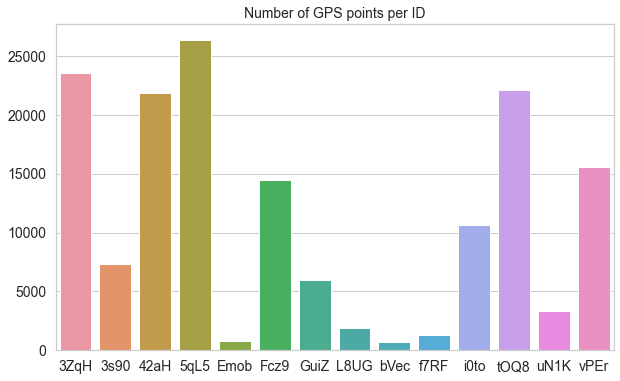

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(x='customer', y='n_data', data=df_int)
plt.title('Number of GPS points per ID',fontsize=14)
plt.ylabel('')
plt.xlabel('')


plt.savefig("barplot_high_quality.png", dpi=300, format='png', bbox_inches='tight')
# Showing the plot
plt.show()



In [29]:
df_int["n_data_day"] = df_int.groupby(["customer", "day"])["Longitude"].transform("size")

In [30]:
df_int.n_data_day.describe()

count    155952.000000
mean       1584.142018
std         916.419743
min           8.000000
25%         870.000000
50%        1523.000000
75%        2068.000000
max        4234.000000
Name: n_data_day, dtype: float64

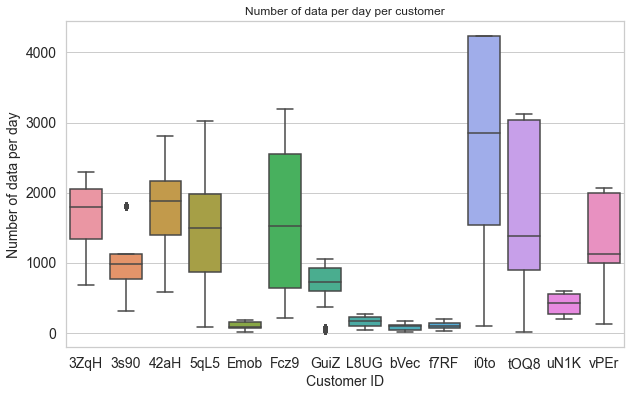

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='customer', y='n_data_day', data=df_int)
plt.title('Number of data per day per customer')
plt.ylabel('Number of data per day')
plt.xlabel('Customer ID')

# Showing the plot
plt.show()

In [32]:
df_int["n_data_hour"] = df_int.groupby(["customer", "day", "hours"])["Longitude"].transform("size")

In [33]:
df_int.n_data_hour.describe()

count    155952.000000
mean        325.712604
std         293.499668
min           1.000000
25%         110.000000
50%         250.000000
75%         421.000000
max        1199.000000
Name: n_data_hour, dtype: float64

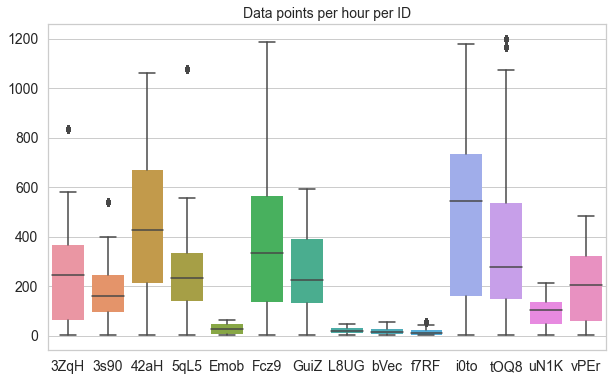

In [34]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='customer', y='n_data_hour', data=df_int, boxprops={"edgecolor": "none"})
plt.title('Data points per hour per ID', fontsize=14)
plt.ylabel('', fontsize=14)
plt.xlabel('', fontsize=14)

plt.savefig("n_data_hour.png", dpi=300, format='png', bbox_inches='tight')
# Showing the plot
plt.show()

In [35]:
def assign_day_index(user_group):
    user_group['day_index'] = (user_group["day"] != user_group["day"].shift()).cumsum()
    return user_group

In [36]:
df_int = df_int.groupby('customer').apply(assign_day_index)

In [37]:
df_int['hourID'] = df_int['customer'].astype(str) + '0' + \
                    df_int['day_index'].astype(str) + '0' + \
                    df_int['hours'].astype(str)

In [38]:
df_single1 = df_int.loc[df_int.customer == "i0to"]

In [39]:
df_single2 = df_int.loc[df_int.customer == "Emob"]

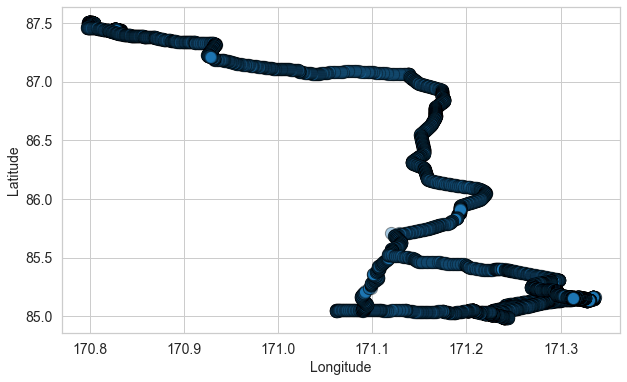

In [40]:
# plot the reduced set of coordinate points
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
rs_scatter = ax.scatter(df_single1['Longitude'], df_single1['Latitude'],edgecolor= "k", alpha=.4, s=150)
 
# set axis labels, tick labels, and title

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.savefig('i0t0_raw.png', dpi=300)

plt.show()

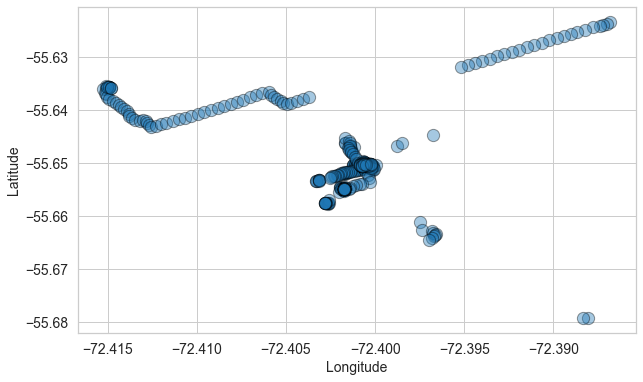

In [41]:
# plot the reduced set of coordinate points
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
rs_scatter = ax.scatter(df_single2['Longitude'], df_single2['Latitude'], edgecolor='k', alpha=.4, s=150)
 
# set axis labels, tick labels, and title

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.savefig('Emob_raw.png', dpi=300)

plt.show()

## Data filtering by converting GPS data to stationary data

In [42]:
# Shift the DataFrame to get previous row’s data
df_speed = df_int.copy()
#df_speed[['prev_customer', 'prev_date', 'prev_longitude', 'prev_latitude']] = df_speed[['customer', 'date', 'Longitude', 'Latitude']].shift(1)

In [43]:
# Haversine formula to calculate distance between two lat/lon points in meters
def haversine(lon1, lat1, lon2, lat2):
    R = 6371000  # Radius of Earth in meters
    phi_1 = np.radians(lat1)
    phi_2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi/2.0)**2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    meters = R * c  # Output distance in meters
    return meters


max_distance = 150  # Example value, adjust as needed

# Initializing columns to store calculated values
df_speed['distance'] = np.nan
df_speed['time_diff'] = np.nan
df_speed['speed'] = np.nan

# Calculating distance, time difference, and speed for each customer independently
for customer in df_speed['customer'].unique():
    mask = df_speed['customer'] == customer
    
    df_speed.loc[mask, 'distance'] = np.concatenate([
        haversine(
            df_speed.loc[mask, 'Longitude'].values[:-1], df_speed.loc[mask, 'Latitude'].values[:-1],
            df_speed.loc[mask, 'Longitude'].values[1:], df_speed.loc[mask, 'Latitude'].values[1:]
        ),
        [0]
    ])
    
    df_speed.loc[mask, 'time_diff'] = df_speed.loc[mask, 'date'].diff().dt.total_seconds().fillna(0)
    
    # Avoid division by zero and replace NaN if time_diff is 0
    df_speed.loc[mask, 'speed'] = df_speed.loc[mask, 'distance'] / df_speed.loc[mask, 'time_diff'].replace(0, np.nan)

# Filtering condition
speed_limit = 1.4  # Max allowed speed in m/s

# Creating the stationary DataFrame
stationary_df = df_speed[(df_speed['speed'] < speed_limit) & (df_speed['distance'] < max_distance)]

# Note: Ensure you inspect and handle NaN values in the 'speed' column appropriately for your use case.

In [44]:
stationary_df = stationary_df[["customer", "date","day", "hours", "Latitude", "Longitude","speed"]]

In [45]:
stationary_df.shape

(41462, 7)

In [46]:
stationary_df.customer.unique()

array(['3ZqH', '3s90', '42aH', '5qL5', 'Emob', 'Fcz9', 'GuiZ', 'L8UG',
       'bVec', 'f7RF', 'i0to', 'tOQ8', 'uN1K', 'vPEr'], dtype=object)

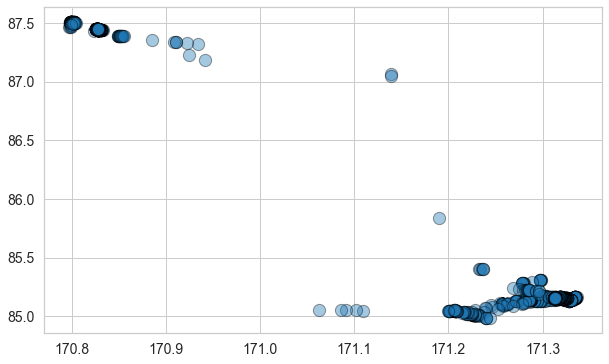

In [47]:
df_single1 = stationary_df.loc[df_int.customer == "i0to"]
# plot the reduced set of coordinate points
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
rs_scatter = ax.scatter(df_single1['Longitude'], df_single1['Latitude'], edgecolor='k', alpha=.4, s=150)
 
# set axis labels, tick labels, and title

ax.set_xlabel('')
ax.set_ylabel('')

plt.savefig('i0t0_filtered.png', dpi=300)

 
plt.show()

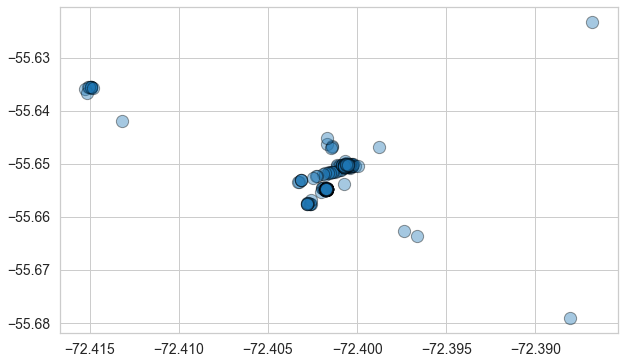

In [48]:
df_single2 = stationary_df.loc[df_int.customer == "Emob"]
# plot the reduced set of coordinate points
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
rs_scatter = ax.scatter(df_single2['Longitude'], df_single2['Latitude'], edgecolor='k', alpha=.4, s=150)
 
# set axis labels, tick labels, and title

ax.set_xlabel('')
ax.set_ylabel('')

plt.savefig('Emob_filtered.png', dpi=300)

 
plt.show()

In [49]:
stationary_df["n_data_hour"] = stationary_df.groupby(["customer", "day", "hours"])["Longitude"].transform("size")
stationary_df["n_data_day"] = stationary_df.groupby(["customer", "day"])["Longitude"].transform("size")

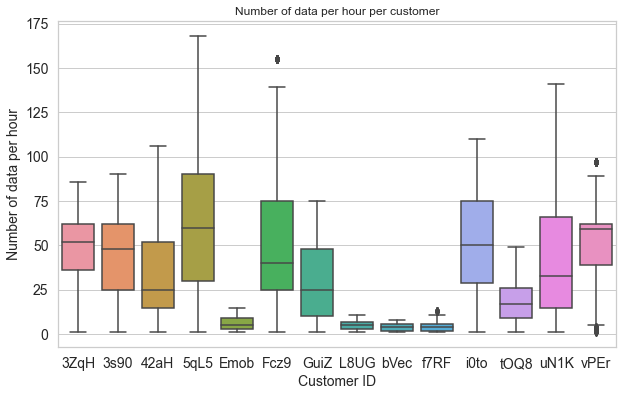

In [50]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='customer', y='n_data_hour', data=stationary_df)
plt.title('Number of data per hour per customer')
plt.ylabel('Number of data per hour')
plt.xlabel('Customer ID')

# Showing the plot
plt.show()

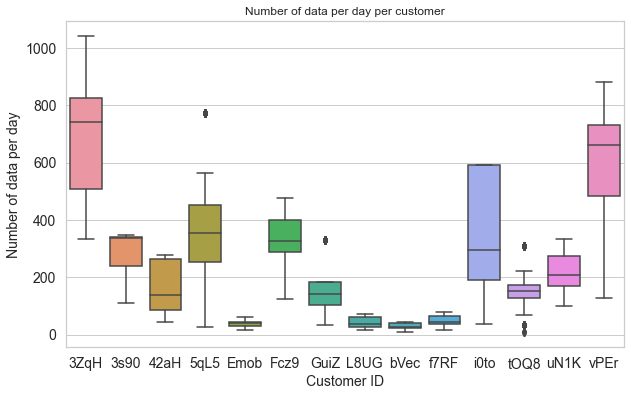

In [51]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='customer', y='n_data_day', data=stationary_df)
plt.title('Number of data per day per customer')
plt.ylabel('Number of data per day')
plt.xlabel('Customer ID')

# Showing the plot
plt.show()

## Transform lon lat coordinates 

In [52]:
# equitorial radius of the earth = 6,378.1 
kms_per_radian = 6371.0088
epsilon = 0.05/kms_per_radian
min_samples = 10

In [53]:
# Function for clustering
def db2(x):
    clustering_model = DBSCAN(eps=epsilon, min_samples=min_samples, metric="haversine")
    cluster_labels = clustering_model.fit_predict(x[['Longitude', 'Latitude']].apply(np.radians))
    return pd.DataFrame({'cluster_100m': cluster_labels})

# Group by 'userID' and apply clustering function
geodata_cluster_df = stationary_df.groupby('customer').apply(lambda x: db2(x)).reset_index()

In [54]:
# Merge this with the main data frame
geodata_clusters = pd.concat([stationary_df.reset_index(drop=True), geodata_cluster_df['cluster_100m']], axis=1)

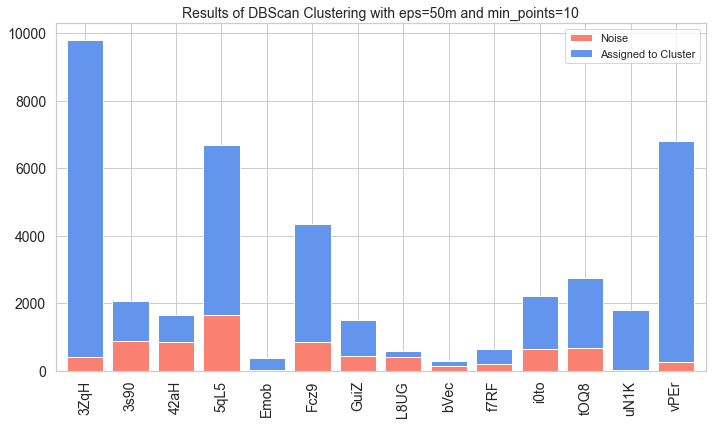

In [55]:
# Initializing a new DataFrame to store processed data
plot_data = pd.DataFrame()

# Calculating the count of "-" values per customer
plot_data['negative_count'] = geodata_clusters[geodata_clusters['cluster_100m'] == -1].groupby('customer').size()

# Calculating the count of non "-" values per customer
plot_data['positive_count'] = geodata_clusters[geodata_clusters['cluster_100m'] != -1].groupby('customer').size()

# Filling NaN with 0s (for customers with no "-" values)
plot_data = plot_data.fillna(0)

# Plotting
ax = plot_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['salmon', 'cornflowerblue'], width=0.8)
plt.title('Results of DBScan Clustering with eps=50m and min_points=10',  fontsize=14)
plt.ylabel('')
plt.xlabel('')

# Adjusting the legend
plt.legend(["Noise", "Assigned to Cluster"], loc='upper right')

plt.savefig('dbscan_count.png', dpi=300)
# Showing the plot
plt.tight_layout()
plt.show()

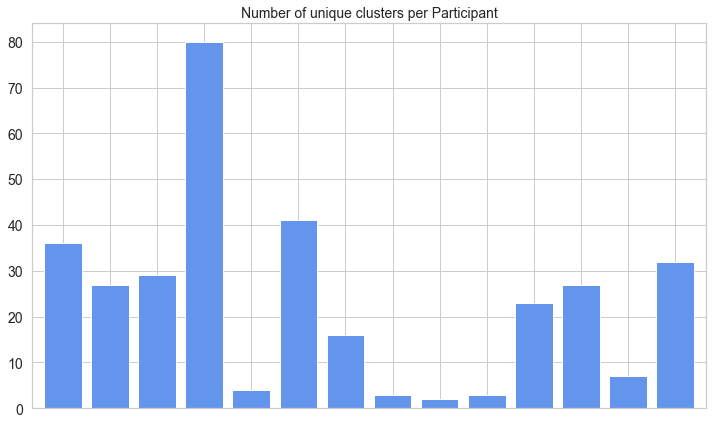

In [56]:
# Calculating the number of unique clusters (excluding -1) per participant
plot_data = geodata_clusters[geodata_clusters['cluster_100m'] != -1].groupby('customer')['cluster_100m'].nunique()

# Plotting
ax = plot_data.plot(kind='bar', figsize=(10, 6), color='cornflowerblue', width=0.8)
ax.set_xticklabels([])
plt.title('Number of unique clusters per Participant', fontsize=14)
plt.ylabel('', fontsize=12)
plt.xlabel('', fontsize=12)

# Showing the plot
plt.tight_layout()
plt.savefig('unique_clusters_per_participant.png', dpi=300, bbox_inches='tight')

plt.show()

In [57]:
customer_set = "i0to"
single_df = geodata_clusters.loc[geodata_clusters.customer==customer_set]

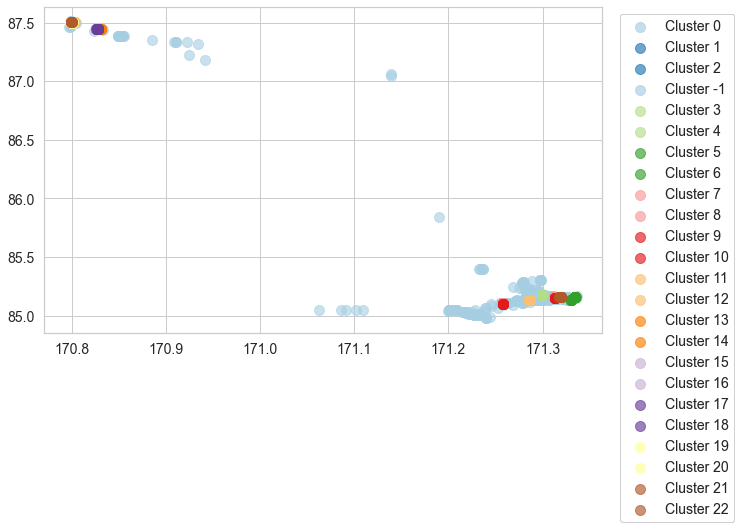

In [58]:
# Create a scatter plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

# Specify colormap
cmap = plt.get_cmap("Paired")

# Get unique cluster values
unique_clusters = single_df['cluster_100m'].unique()

# Normalize cluster values to [0,1] for colormap mapping
norm = plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))

# Loop through unique cluster values, plotting each separately with a label
scatters = []
for cluster in unique_clusters:
    filtered_data = single_df[single_df['cluster_100m'] == cluster]
    if cluster == -1:
        label = 'Noise'
    else:
        label = f'Cluster {cluster}'
        
    sc = ax.scatter(filtered_data['Longitude'], filtered_data['Latitude'],
                    color=cmap(norm(cluster)), alpha=.6, s=100, 
                    label=f'Cluster {cluster}')
    scatters.append(sc)

# Create a legend
legend1 = ax.legend(handles=scatters, bbox_to_anchor=(1.02, 1),fontsize=14)
ax.add_artist(legend1)

# Adding axis labels and show the plot
ax.set_xlabel('')
ax.set_ylabel('')

plt.savefig('i0to_clustered.png', dpi=300, bbox_inches='tight')

plt.show()

In [59]:
geodata_clusters = geodata_clusters[geodata_clusters['cluster_100m'] != -1]

In [60]:
geodata_clusters.shape

(34064, 10)

In [61]:
# Generate unique IDs for clusters
geodata_clusters['clusterID'] = geodata_clusters['customer'].astype(str) + '00' + \
geodata_clusters['cluster_100m'].astype(str)

## Generate Home Location from data

In [62]:
# Filter data for night hours (midnight to 6:00 am)
geodata_night = geodata_clusters.loc[(geodata_clusters['hours'] >= 0) & (geodata_clusters['hours'] < 6)]

# Find the mode of clusterID per user during night hours
geodata_night = geodata_night.copy()
geodata_night['home'] = geodata_night.groupby('customer')['clusterID'].transform(lambda x: mode(x)[0][0])

In [63]:
# Calculating various metrics to validate the home cluster
geodata_night['nights_with_obs'] = geodata_night.groupby('customer')['day'].transform('nunique')
geodata_night['night_obs'] = geodata_night.groupby('customer')['day'].transform('size')


In [64]:
# Finding the frequency of the mode
geodata_night['n_home'] = geodata_night.groupby('customer')['home'].transform(lambda x: x.value_counts().iloc[0])
geodata_night['f_home'] = geodata_night['n_home'] / geodata_night['night_obs']

# Updating the 'home' label based on conditions
geodata_night['home'] = geodata_night.apply(
    lambda x: x['home'] if x['nights_with_obs'] >= 7 and x['f_home'] > 0.5 else None, axis=1
)

# Extracting a mapping of userID to home cluster
user_home_mapping = geodata_night[['customer', 'home']].drop_duplicates()

# Merging back to the full dataset
geodata_clusters = pd.merge(geodata_clusters, user_home_mapping, on='customer', how='left')

In [65]:
geodata_clusters.groupby("customer")["home"].unique()

customer
3ZqH    [3ZqH000]
3s90       [None]
42aH       [None]
5qL5    [5qL5003]
Emob        [nan]
Fcz9    [Fcz9002]
GuiZ       [None]
L8UG       [None]
bVec        [nan]
f7RF    [f7RF000]
i0to       [None]
tOQ8    [tOQ8005]
uN1K       [None]
vPEr    [vPEr000]
Name: home, dtype: object

In [66]:
# Grab relevant columns
cbusdata = geodata[['customer', 'date']]
clusterdata = geodata_clusters[['customer', 'date', 'clusterID']]

# Merge dataframes
df_int = pd.merge(df_int, clusterdata, how='left', on=['customer', 'date'])
df_int = pd.merge(df_int, cbusdata, how='left', on=['customer', 'date'])

# Order the data
df_int = df_int.sort_values(by=['customer', 'date'])


NameError: name 'geodata' is not defined

In [ ]:
df_int.head(50)

In [ ]:
# Function to shift vectors
def shift_vector(vec, shift):
    if shift > 0:
        return np.concatenate((np.full(shift, np.nan), vec[:-shift]))
    elif shift < 0:
        return np.concatenate((vec[-shift:], np.full(-shift, np.nan)))
    else:
        return vec

# Shift vectors for lat and long
df_int['lat_p1'] = df_int.groupby('customer')['Longitude'].transform(lambda x: shift_vector(x, -1))
df_int['lon_p1'] = df_int.groupby('customer')['Latitude'].transform(lambda x: shift_vector(x, -1))

# haversine formula for distance calculation between two lat,lon points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # radius of Earth in meters
    phi_1 = np.radians(lat1)
    phi_2 = np.radians(lat2)
    
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi/2.0)**2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda/2.0)**2
    
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    meters = R * c  # output distance in meters
    return meters

# Calculate distance (in meters) using the haversine function
df_int['dist_to_prev'] = haversine(df_int['Latitude'], df_int['Longitude'], df_int['lat_p1'], df_int['lon_p1'])

# Shift vectors for clusterID
df_int['clusterID_p1'] = df_int.groupby('customer')['clusterID'].transform(lambda x: shift_vector(x, -1))

# Set distance traveled to 0 if the cluster was the same
df_int.loc[df_int['clusterID'] == df_int['clusterID_p1'], 'dist_to_prev'] = 0

# Aggregate distance for each user
agg = df_int.groupby('customer')['dist_to_prev'].sum().reset_index(name='distanceM')
agg['distanceKM'] = agg['distanceM'] / 1000

# Add to main dataframe
df_int = pd.merge(df_int, agg, on='customer')